In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
#import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

sys.path.insert(1, os.path.join(sys.path[0], '..'))

from SEIR.utils import config

In [2]:
max_files = 10
config = 'config_compare_outcome.yml'

In [3]:
folder = [x for x in Path('hospitalization_old/model_output/').glob('*') if not x.is_file()]

all_hosp_sim = {}

for fold in folder:
    if ('importation' not in str(fold)):
        data = []
        print(f'loading {str(fold)[29:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            if files_loaded < max_files and 'high' in str(filename):
                sim = pd.read_csv(filename)
                sim = sim.groupby('time').sum()
                sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid'

                data.append(sim)
                files_loaded += 1
        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files and 'high' in str(filename):
                sim = pq.read_table(filename).to_pandas()
                sim = sim.groupby('time').sum()
                sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid' 'sim_num', 'sim_num_good',
                data.append(sim)
                files_loaded += 1

        print(f'... {len(data)} loaded')
        all_hosp_sim [str(fold)[29:]] = data

try:
    config.set_file(config_file)
    dates = config["report"]["formatting"]["display_dates"].get()
    print('loaded config sucessfuly')
except:
    dates = []
    dates.append(str(sim.index[-1]))
    print('Failed to load config, using only endate')

loading put/east-coast_Uncontrolled ... ... 10 loaded
loading put/east-coast_SocialDistancing_pulsed ... ... 10 loaded
loading put/east-coast_SocialDistancing_fatigued ... ... 10 loaded
loading put/east-coast_SocialDistancing_checker ... ... 10 loaded
loading put/east-coast_SocialDistancing_fixed ... ... 10 loaded
Failed to load config, using only endate


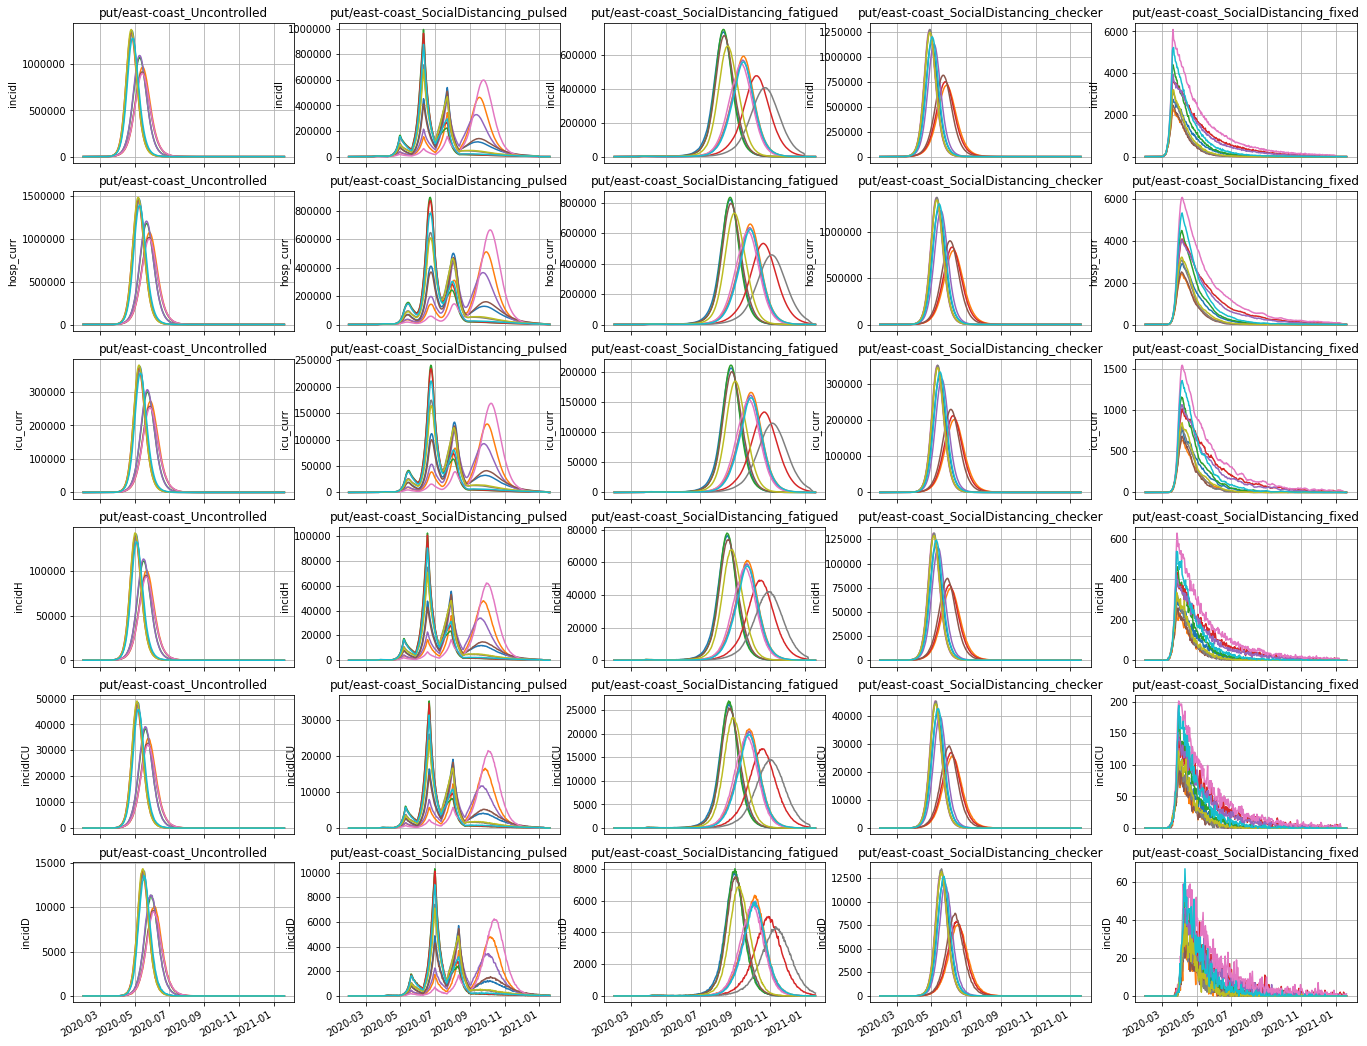

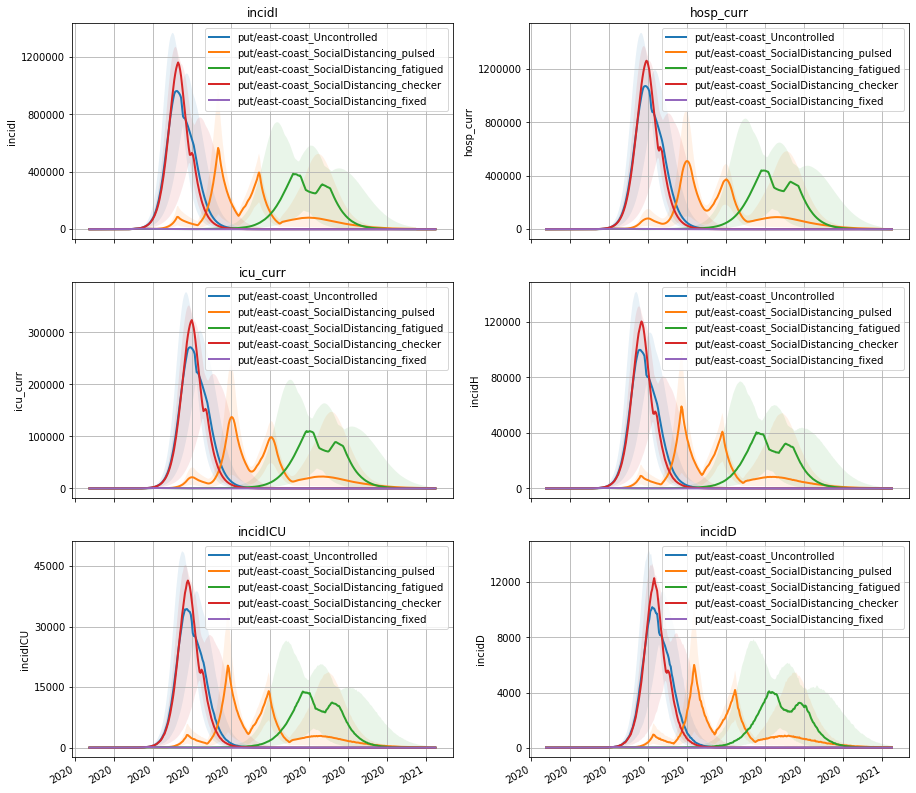

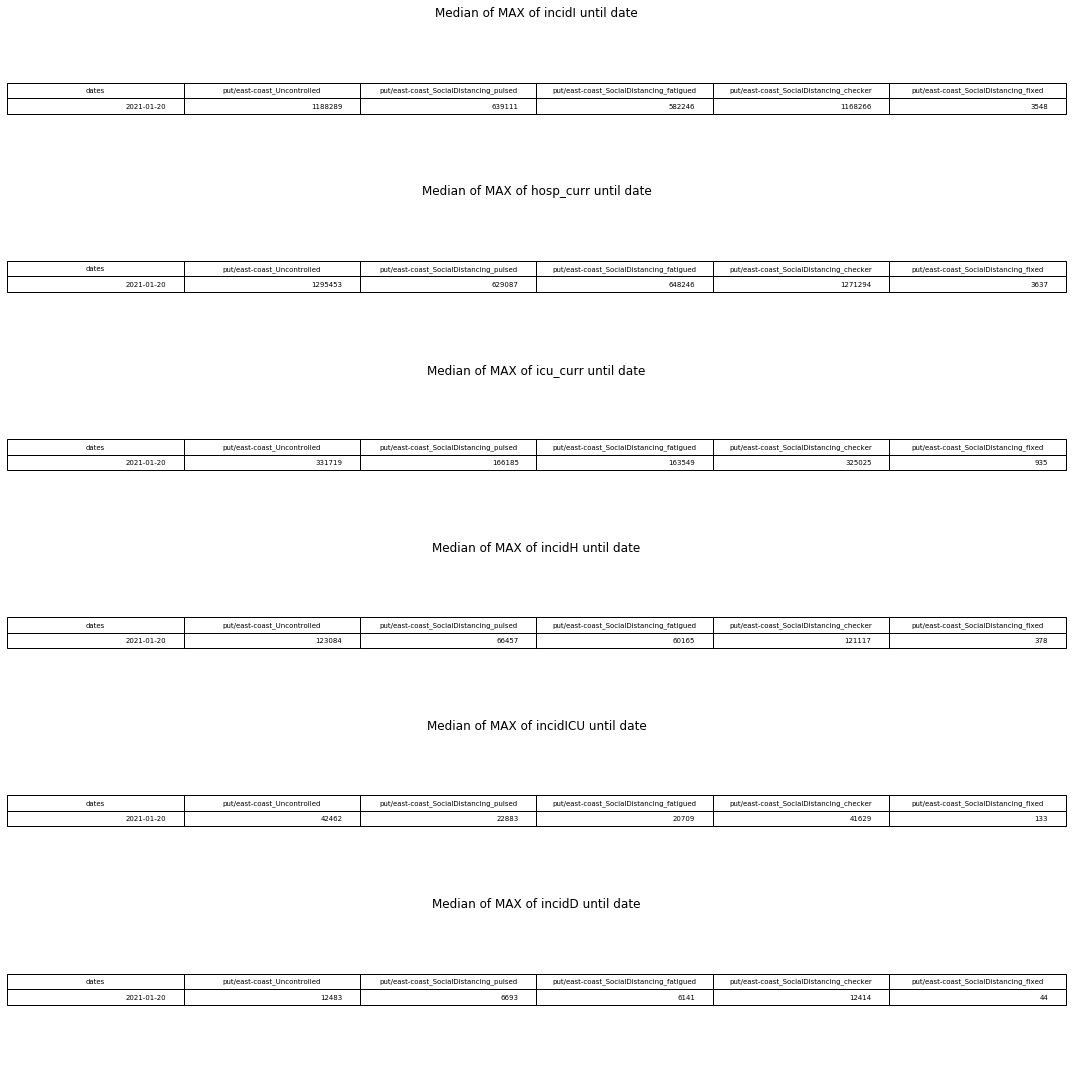

In [4]:
pdf = PdfPages('old-hosp.pdf')
d = pdf.infodict()
d['Title'] = 'Fast report of current runs'
d['Author'] = 'IDDynamics at JHU'
varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot),len(all_hosp_sim), figsize =(23,20), sharex=True)
for vi, var in enumerate(varplot):
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        if len(all_hosp_sim) > 1:
            ax = axes[vi][scn]
        else:
            ax = axes[vi]
        ax.set_title(key)
        #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.grid()
        ax.set_ylabel(var)
        for sim in all_hosp_sim[key]:
            ax.plot(sim[var])
    fig.autofmt_xdate()

pdf.savefig(fig)

fig, axes = plt.subplots(len(varplot)//2,2, figsize =(15,15), sharex=True)
for vi, var in enumerate(varplot):
    ax = axes.flat[vi]
    ax.set_title(var)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid()
    ax.set_ylabel(var)
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)

        ax.plot(temp.quantile(.5, axis = 1), label = key,linewidth = 2)
        ax.fill_between(temp.index, temp.quantile(.05, axis = 1), 
                      temp.quantile(.95, axis = 1), alpha =.1)
        ax.legend()

    fig.autofmt_xdate()
pdf.savefig(fig)



fig, axes = plt.subplots(len(varplot),1, figsize =(15,15))

for i, var in enumerate(varplot):
    ax = axes.flat[i]
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(f'Median of MAX of {var} until date')
    col = list(all_hosp_sim.keys())
    col.insert(0, 'dates')
    df = pd.DataFrame(0, columns=col, index = dates)
    df['dates'] = dates
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)

        for j, d in enumerate(dates):
            df.iloc[j,scn+1] = int(temp[:datetime.datetime.strptime(d, '%Y-%m-%d').date()].max().quantile(.5))


    ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
pdf.savefig(fig)
pdf.close()

In [6]:
folder = [x for x in Path('hospitalization_new/model_output/').glob('*') if not x.is_file()]

all_hosp_sim = {}

for fold in folder:
    if ('importation' not in str(fold)):
        data = []
        print(f'loading {str(fold)[29:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files and 'high' in str(filename):
                sim = pq.read_table(filename).to_pandas()
                sim = sim.groupby('time').sum()
                #sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid' 'sim_num', 'sim_num_good',
                data.append(sim)
                files_loaded += 1

        print(f'... {len(data)} loaded')
        all_hosp_sim [str(fold)[29:]] = data

try:
    config.set_file(config_file)
    dates = config["report"]["formatting"]["display_dates"].get()
    print('loaded config sucessfuly')
except:
    dates = []
    dates.append(str(sim.index[-1]))
    print('Failed to load config, using only endate')

loading put/east-coast_Uncontrolled ... ... 10 loaded
loading put/east-coast_SocialDistancing_pulsed ... ... 10 loaded
loading put/east-coast_SocialDistancing_fatigued ... ... 10 loaded
loading put/east-coast_SocialDistancing_checker ... ... 10 loaded
loading put/east-coast_SocialDistancing_fixed ... ... 10 loaded
Failed to load config, using only endate


ValueError: unconverted data remains:  00:00:00

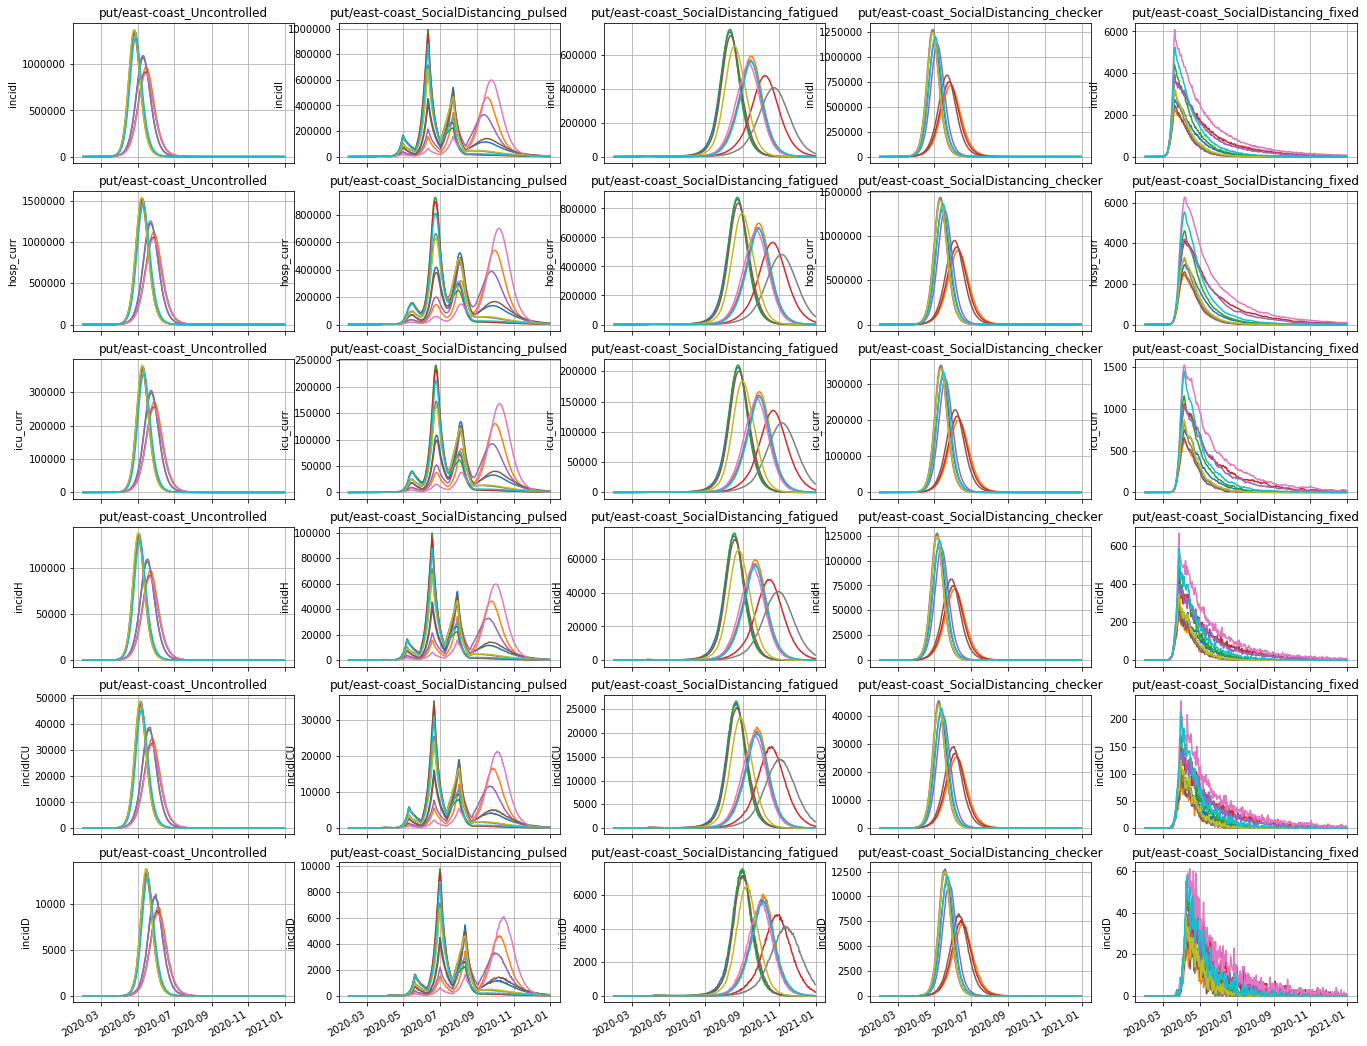

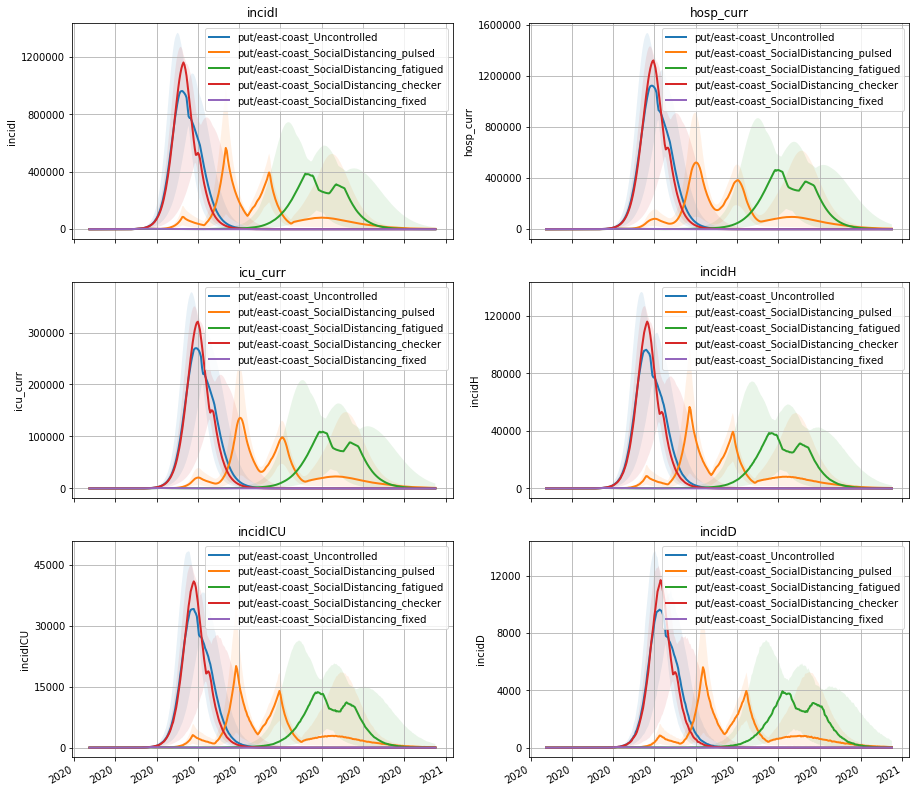

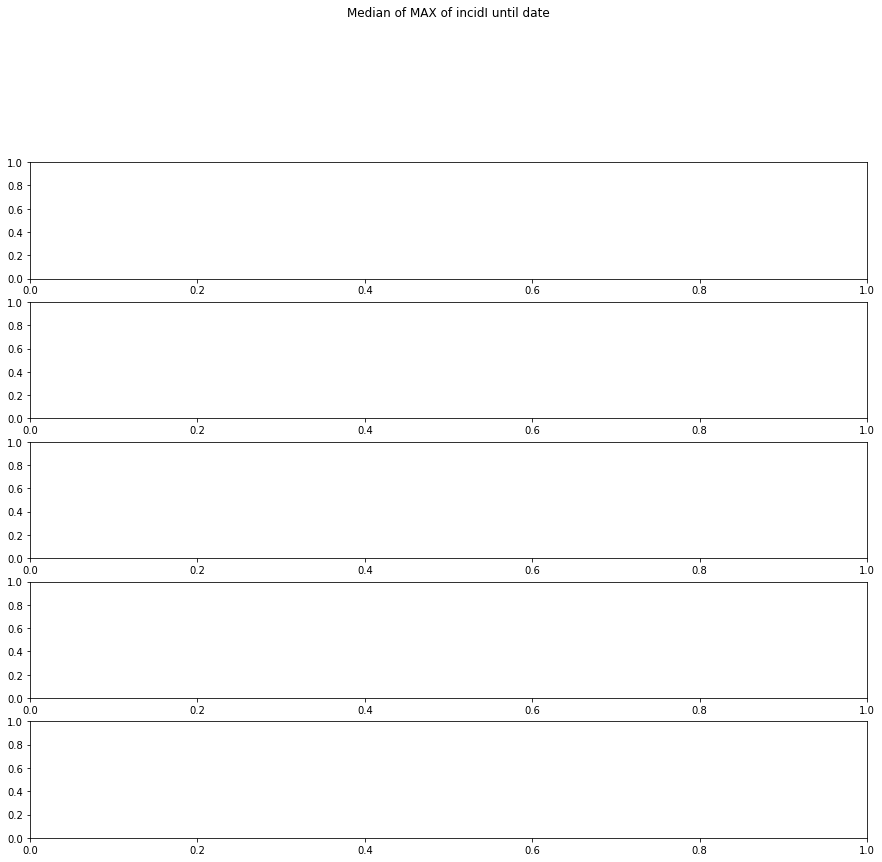

In [7]:
pdf = PdfPages('new-hosp.pdf')
d = pdf.infodict()
d['Title'] = 'Fast report of current runs'
d['Author'] = 'IDDynamics at JHU'
varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot),len(all_hosp_sim), figsize =(23,20), sharex=True)
for vi, var in enumerate(varplot):
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        if len(all_hosp_sim) > 1:
            ax = axes[vi][scn]
        else:
            ax = axes[vi]
        ax.set_title(key)
        #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.grid()
        ax.set_ylabel(var)
        for sim in all_hosp_sim[key]:
            ax.plot(sim[var])
    fig.autofmt_xdate()

pdf.savefig(fig)

fig, axes = plt.subplots(len(varplot)//2,2, figsize =(15,15), sharex=True)
for vi, var in enumerate(varplot):
    ax = axes.flat[vi]
    ax.set_title(var)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid()
    ax.set_ylabel(var)
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)

        ax.plot(temp.quantile(.5, axis = 1), label = key,linewidth = 2)
        ax.fill_between(temp.index, temp.quantile(.05, axis = 1), 
                      temp.quantile(.95, axis = 1), alpha =.1)
        ax.legend()

    fig.autofmt_xdate()
pdf.savefig(fig)



fig, axes = plt.subplots(len(varplot),1, figsize =(15,15))

for i, var in enumerate(varplot):
    ax = axes.flat[i]
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(f'Median of MAX of {var} until date')
    col = list(all_hosp_sim.keys())
    col.insert(0, 'dates')
    df = pd.DataFrame(0, columns=col, index = dates)
    df['dates'] = dates
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)

        for j, d in enumerate(dates):
            df.iloc[j,scn+1] = int(temp[:datetime.datetime.strptime(d, '%Y-%m-%d').date()].max().quantile(.5))


    ax.table(cellText=df.values, colLabels=df.columns, loc='center')

fig.tight_layout()
pdf.savefig(fig)
pdf.close()

In [8]:
pdf.close()

In [ ]:

    
varplot = ['infection', 'incidH_curr', 'incidICU_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot)//2,2, figsize =(15,15), sharex=True)
for vi, var in enumerate(varplot):
    ax = axes.flat[vi]
    ax.set_title(var)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid()
    ax.set_ylabel(var)
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            sim['infection'] = sim['incidI']
            sim['incidH_curr'] = sim['hosp_curr']
            sim['incidICU_curr'] = sim['icu_curr']
            temp = sim[var]
            sim_of_var.append(temp)
        temp_old = pd.concat(sim_of_var, axis=1)
        
        out_of_var = []
        for sim in all_out_sim[key]:
            temp = sim[var]
            out_of_var.append(temp)
        temp_new = pd.concat(out_of_var,axis=1)

        ax.plot(temp_old.quantile(.5, axis = 1) - temp_new.quantile(.5, axis = 1), label = key,linewidth = 2)
        ax.fill_between(temp_old.index, temp_old.quantile(.05, axis = 1) - temp_new.quantile(.05, axis = 1), 
                      temp_old.quantile(.95, axis = 1)-temp_new.quantile(.95, axis = 1), alpha =.1)
        ax.legend()

    fig.autofmt_xdate()
